In [178]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
# Here's how to run the c code:
# (this code interpolates rays + damping onto a uniform time axis,
# then calculates geometric spreading at the center of each "tube", defined
# by four corner rays. The result is a measure of wave power density (w/m^2) at
# each timestep. )


ray_inp_dir = '/shared/users/asousa/WIPP/lightning_power_study/rays/globes/ngo_igrf/'
f1 = 3920
f2 = 4580
time_max = 3.0
num_times = 30
max_ground_distance = 700
freq_step_size=500
flash_lat = 50
flash_lon = 84
outfile_name= '/shared/users/asousa/WIPP/lightning_power_study/power_vectors_%d_%d.dat'%(f1, f2)

cmd = '../bin/main --ray_dir=%s --out_file=%s'%(ray_inp_dir, outfile_name) + \
        ' --f1=%d --f2=%d --t_max=%g --num_times=%d'%(f1, f2, time_max, num_times) + \
        ' --max_dist=%d --freq_step_size=%d'%(max_ground_distance, freq_step_size) + \
        ' --lat=%d --lon=%d'%(flash_lat, flash_lon)
        
print cmd


ret_val = os.system(cmd)

if ret_val != 0:
    print "C code threw some error... Hmm."
else:
    print "finished!"

../bin/main --ray_dir=/shared/users/asousa/WIPP/lightning_power_study/rays/globes/ngo_igrf/ --out_file=/shared/users/asousa/WIPP/lightning_power_study/power_vectors_3920_4580.dat --f1=3920 --f2=4580 --t_max=3 --num_times=30 --max_dist=700 --freq_step_size=500 --lat=50 --lon=84
finished!


(1, 6, 30, 4)
(4, 4)
xz min, max:  -inf 8.82384189575


<IPython.core.display.Javascript object>


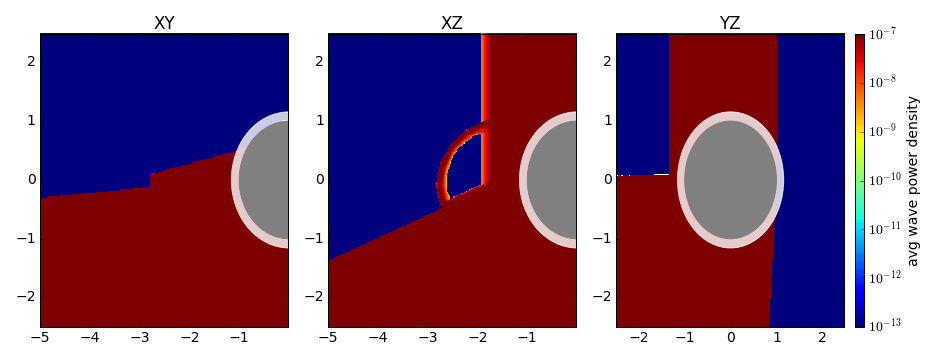

In [206]:
# Load file (sparse list of coordinates + powers, vs time)
# fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'
fname = outfile_name
data_raw = np.loadtxt(fname)

R_E = 6371e3
H_IONO = 1000e3
nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)



import scipy.interpolate
XMIN =-5
XMAX =0
YMIN =-2.5
YMAX =2.5
ZMIN =-2.5
ZMAX =2.5
GRID_STEP_SIZE =0.02

clims = [-13,-7]

xx = np.arange(XMIN, XMAX, GRID_STEP_SIZE)
yy = np.arange(YMIN, YMAX, GRID_STEP_SIZE)
zz = np.arange(ZMIN, ZMAX, GRID_STEP_SIZE)

nx = len(xx) 
ny = len(yy)
nz = len(zz)

data = np.zeros([nx, ny, nz])
# hits = np.zeros([nx, ny, nz])

# Find adjacent sets of power vectors:
starting_coords = dgrid[0,:,0,0:3]

# print np.shape(starting_coords)
adj_inds = np.zeros([np.shape(starting_coords)[0],4], dtype='int')

for r_ind, row in enumerate(starting_coords):
    dists = np.linalg.norm(row - starting_coords, axis=1)
    dinds = np.argsort(dists)
    adj_inds[r_ind,:] = sorted(dinds[0:4])

sorted_data = adj_inds[np.lexsort(adj_inds.T),:]
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
adj_inds = sorted_data[row_mask]

print np.shape(adj_inds)
# Interpolate over each little 8-corner box:
for f_ind in range(nf):
    for t in range(1,nt):
        hits = np.zeros([nx, ny, nz])
        for adj_row in adj_inds:
#             try:
            points = dgrid[f_ind,adj_row,t-1:t+2,0:3]
            vals = dgrid[f_ind,adj_row,t-1:t+2,3]
            vals_flat = vals.ravel()
            points_flat = np.vstack([points[:,:,0].ravel(), points[:,:,1].ravel(), points[:,:,2].ravel()]).T
            minx = min(points_flat[:,0])
            maxx = max(points_flat[:,0])
            miny = min(points_flat[:,1])
            maxy = max(points_flat[:,1])
            minz = min(points_flat[:,2])
            maxz = max(points_flat[:,2])

            ix = np.where((xx >= minx) & (xx <= maxx))[0]
            iy = np.where((yy >= miny) & (yy <= maxy))[0]
            iz = np.where((zz >= minz) & (zz <= maxz))[0]

            px, py, pz = np.meshgrid(ix, iy, iz)

            newpoints = np.vstack([xx[px.ravel()], yy[py.ravel()], zz[pz.ravel()]]).T
            newinds   = np.vstack([px, py, pz]).T
            # If we don't specify a fill value, 'linear' mode returns NaN for anything outside
            # the convex hull of the current point cloud (which is ideal -- we don't want any
            # values calculated outside the (non-convex) hull.)
            tmp_data = interpolate.griddata(points_flat, vals_flat, newpoints, method='linear', rescale=True)
            tmp_data = tmp_data.reshape([len(iy), len(ix), len(iz)])
            isnans = np.isnan(tmp_data)
            tmp_data[np.isnan(tmp_data)] = 0

#             print np.sum(isnans), np.sum(~isnans)
            data[px,py,pz] += tmp_data
            hits[px,py,pz] += ~isnans
#             except:
#                 print "bork"
        data[hits!=0] /= hits[hits!=0]
#         data /= (1 + hits)
    
    xz_sum = np.log10((np.sum(data, axis=1).T)/len(yy))
    xy_sum = np.log10((np.sum(data, axis=2).T)/len(zz))
    yz_sum = np.log10((np.sum(data, axis=0).T)/len(xx))
    
    print "xz min, max: ", np.min(xz_sum), np.max(xz_sum)

    xy_sum[np.isinf(xy_sum)] = -100
    xz_sum[np.isinf(xz_sum)] = -100
    yz_sum[np.isinf(yz_sum)] = -100

    fig, ax = plt.subplots(1,3)
    # Plot the earth
    for i in [0, 1, 2]:
        earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
        iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
        ax[i].add_patch(earth)   
        ax[i].add_patch(iono)
    
    p0 = ax[0].pcolorfast(xx, yy, xy_sum, vmin=clims[0], vmax=clims[1])
    p1 = ax[1].pcolorfast(xx, zz, xz_sum, vmin=clims[0], vmax=clims[1])
    p2 = ax[2].pcolorfast(yy, zz, yz_sum, vmin=clims[0], vmax=clims[1])

    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes("right",size="4%",pad=0.15)
    cb = plt.colorbar(p2, cax=cax)
    cb.set_label('avg wave power density')
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)
    
#     ax[0].set_aspect('equal')
#     ax[1].set_aspect('equal')
#     ax[2].set_aspect('equal')

    ax[0].set_title('XY')
    ax[1].set_title('XZ')
    ax[2].set_title('YZ')
    
    ax[0].set_xlim([xx[0],xx[-1]])
    ax[0].set_ylim([yy[0],yy[-1]])
    ax[1].set_xlim([xx[0],xx[-1]])
    ax[1].set_ylim([zz[0],zz[-1]])
    ax[2].set_xlim([yy[0],yy[-1]])
    ax[2].set_ylim([zz[0],zz[-1]])
    
    
    

    
    fig.tight_layout()



<IPython.core.display.Javascript object>


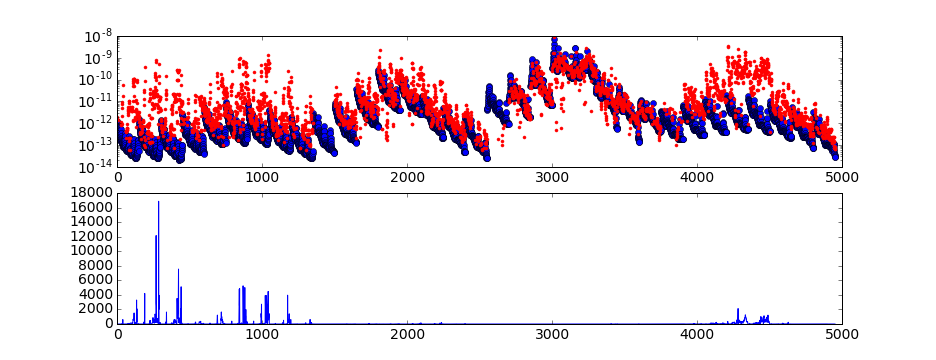

In [192]:
# Check how well it matches with the known data:

# Find closest values in interpolated grid to the current rays:

xraw = dgrid[:,:,:,0].ravel()
yraw = dgrid[:,:,:,1].ravel()
zraw = dgrid[:,:,:,2].ravel()
data_raw = dgrid[:,:,:,3].ravel()

# Quantize to our sampling grid
xq   = np.digitize(xraw, xx)
yq   = np.digitize(yraw, yy)
zq   = np.digitize(zraw, zz)

dq = data[xq, yq, zq]

fig, ax = plt.subplots(2,1)

ax[0].semilogy(data_raw,'bo')
ax[0].semilogy(dq,'r.')

ax[1].plot(abs(data_raw - dq)/abs(data_raw))


In [22]:
starting_coords = dgrid[0,:,0,0:3]

print np.shape(starting_coords)
adj_inds = np.zeros([np.shape(starting_coords)[0],4])

for r_ind, row in enumerate(starting_coords):
    dists = np.linalg.norm(row - starting_coords, axis=1)
    dinds = np.argsort(dists)
    adj_inds[r_ind,:] = sorted(dinds[0:4])

sorted_data = adj_inds[np.lexsort(adj_inds.T),:]
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=0),1))
adj_inds = sorted_data[row_mask]

print adj_inds


print row


points = dgrid[f_ind,row,t-1:t+2,0:3]

(12, 3)
[[  0.   1.   2.   3.]
 [  0.   1.   3.   4.]
 [  2.   3.   4.   7.]
 [  2.   3.   6.   7.]
 [  3.   4.   5.   8.]
 [  4.   5.   8.   9.]
 [  2.   6.   7.  10.]
 [  6.   7.   8.  10.]
 [  5.   8.   9.  11.]
 [  7.   8.   9.  11.]
 [  6.   7.  10.  11.]
 [  7.   8.  10.  11.]]
[-0.935204 -0.164981  0.919887]


IndexError: arrays used as indices must be of integer (or boolean) type

(1, 6, 30, 4)


<IPython.core.display.Javascript object>


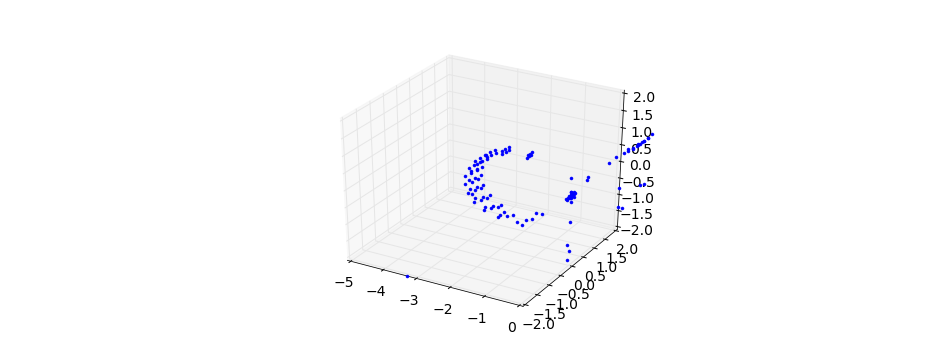

(-2, 2)

In [207]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Handy 3d plotter to show where the original power samples are:

# Load file (sparse list of coordinates + powers, vs time)
# fname = '/shared/users/asousa/WIPP/lightning_power_study/test_dump_prev.dat'

data_raw = np.loadtxt(outfile_name)

nf = int(data_raw[0]) # num frequencies
nv = int(data_raw[1]) # num vectors
nt = int(data_raw[2]) # num timesteps

dgrid = data_raw[3:]

dgrid = np.reshape(dgrid, [nf,nv,nt,4],order='c')
# dgrid = np.reshape(dgrid, [nf*nv*nt,4],order='c')

print np.shape(dgrid)


f_ind = 0;




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for v in range(nv):
    ax.plot(dgrid[0,v,:,0],dgrid[0,v,:,1],dgrid[0,v,:,2],'b.')

# ax.plot(dgrid[:,0],dgrid[:,1],dgrid[:,2],'b.')


ax.set_aspect('equal')
ax.set_xlim([-5,0])
ax.set_ylim([-2,2])
ax.set_zlim([-2,2])


In [115]:
adj_inds

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

<IPython.core.display.Javascript object>


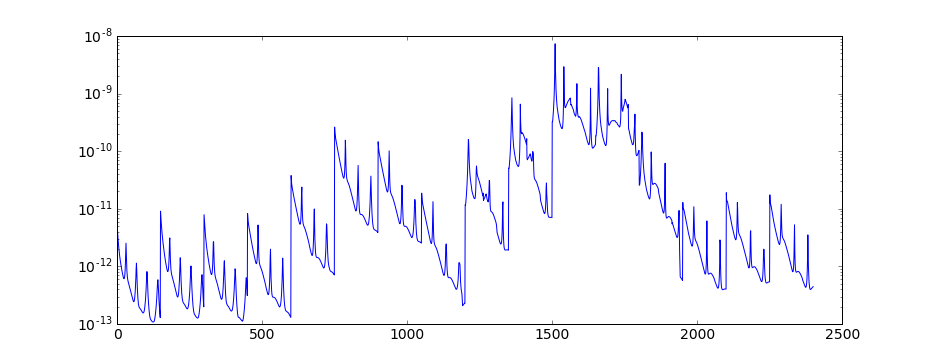

In [92]:
plt.figure()
plt.semilogy(dgrid[:,:,:,3].flatten())

<IPython.core.display.Javascript object>


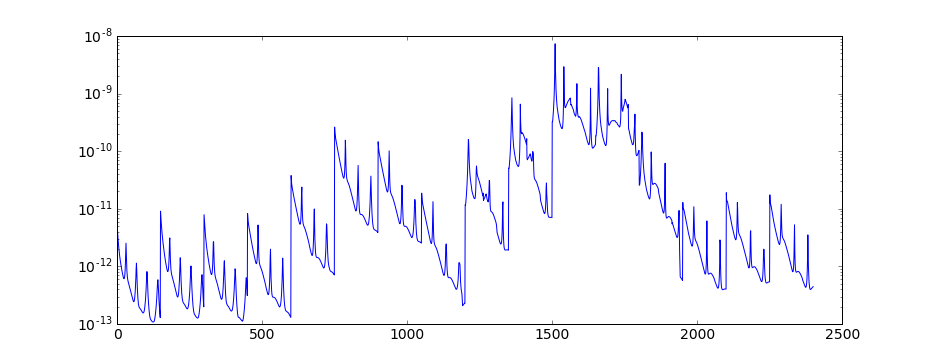

In [95]:
plt.figure()
plt.semilogy(dgrid[:,:,:,3].flatten())

In [162]:
import xflib  # Fortran xform-double library (coordinate transforms)
# Coordinate transformation library
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')


# Find adjacent rays (by sorting latitude and longitude rather than distance metric)
starting_coords = dgrid[0,:,0,0:3]

# Convert to spherical coords:
flashtime = dt.datetime(2001, 1, 1, 0, 0, 0)

starting_coords_polar = np.zeros_like(starting_coords)

for row_ind, row in enumerate(starting_coords):
    starting_coords_polar[row_ind,:] = xf.sm2rllmag(row, flashtime)
    
overlaps = np.zeros([len(adj_inds), len(adj_inds)])
for p1_ind, p1 in enumerate(adj_inds):
    for p2_ind, p2 in enumerate(adj_inds):
#     print np.shape(starting_coords_polar[p1])
        p1latmin = min(starting_coords_polar[p1][:,1])
        p1latmax = max(starting_coords_polar[p1][:,1])
        p1lonmin = min(starting_coords_polar[p1][:,2])
        p1lonmax = max(starting_coords_polar[p1][:,2])
        p2latmin = min(starting_coords_polar[p2][:,1])
        p2latmax = max(starting_coords_polar[p2][:,1])
        p2lonmin = min(starting_coords_polar[p2][:,2])
        p2lonmax = max(starting_coords_polar[p2][:,2])

#         print p1latmin, p1latmax, p1lonmin, p1lonmax
        dlat = min(p1latmax, p2latmax) - max(p1latmin, p2latmin)
        dlon = min(p1lonmax, p2lonmax) - max(p1lonmin, p2lonmin)
        overlaps[p1_ind, p2_ind] = dlat*dlon
        

novers = np.array(np.where(overlaps==0))


sorted_data = adj_inds[np.lexsort(novers.T),:]
row_mask = np.append([True],np.any(np.diff(sorted_data,axis=1),1))
novers = sorted_data[row_mask.T]# plt.figure()

print novers
# plt.hist(overlaps.flatten())

/shared/users/asousa/software/python2/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 3


IndexError: index 2 is out of bounds for axis 0 with size 2

In [122]:
# Do the adjacency checking the same way as before, but eliminate overlapping boxes:


# print starting_coords
# print adj_inds

for p1_ind, p1 in enumerate(adj_inds):
    print starting_coords[p1][]
#     for p2_ind, p2 in enumerate(adj_inds):
        
        
#         print p1_ind, p2_ind

# dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
# dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
# if (dx>=0) and (dy>=0):
#     return dx*dy

    

[[-0.930965   -0.00801491  0.806544  ]
 [-0.927362   -0.0883744   0.807944  ]
 [-0.864458    0.0674763   0.89233   ]
 [-0.867432   -0.00715941  0.893396  ]]
[[-0.930965   -0.00801491  0.806544  ]
 [-0.927362   -0.0883744   0.807944  ]
 [-0.916812   -0.168318    0.809463  ]
 [-0.863858   -0.0819353   0.894603  ]]
[[-0.927362  -0.0883744  0.807944 ]
 [-0.916812  -0.168318   0.809463 ]
 [-0.863858  -0.0819353  0.894603 ]
 [-0.853854  -0.15627    0.895932 ]]
[[-0.864458    0.0674763   0.89233   ]
 [-0.867432   -0.00715941  0.893396  ]
 [-0.863858   -0.0819353   0.894603  ]
 [-0.805125   -0.00599312  0.974352  ]]
[[-0.864458    0.0674763   0.89233   ]
 [-0.867432   -0.00715941  0.893396  ]
 [-0.802427    0.0631047   0.973431  ]
 [-0.805125   -0.00599312  0.974352  ]]
[[-0.867432   -0.00715941  0.893396  ]
 [-0.863858   -0.0819353   0.894603  ]
 [-0.853854   -0.15627     0.895932  ]
 [-0.801799   -0.0752173   0.97541   ]]
[[-0.863858  -0.0819353  0.894603 ]
 [-0.853854  -0.15627    0.895932 